In [11]:
%matplotlib notebook

import sys
import numpy as np
import cv2
import cvk2
from osgeo import gdal,ogr,osr
from pyproj import Proj
import georefUtils_py3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pdb

In [39]:
numPointCorrespondences = 10
print("\nYou can find your UTM zone here: http://www.latlong.net/lat-long-utm.html")
#utmZone = raw_input("Enter the UTM Zone (2L for Ofu): ")
utmZone = "2L"

# Read images
googleEarthPath = "./images/Im_air_googleEarth2014_lowres.jpg"
googleEarth = cv2.imread(googleEarthPath,0)
UavPath = "./images/Im_air.tif"
UAV = cv2.imread(UavPath,0)

largeAerialPath = "../images/Aerial_RGB_2012.tif"
aerial_gtif = gdal.Open(largeAerialPath)

print("Driver: {}/{}".format(aerial_gtif.GetDriver().ShortName,
                             aerial_gtif.GetDriver().LongName))
print("Size is {} x {} x {}".format(aerial_gtif.RasterXSize,
                                    aerial_gtif.RasterYSize,
                                    aerial_gtif.RasterCount))
print("Projection is {}".format(aerial_gtif.GetProjection()))

# Transect1Path = "../images/Transect 1 Hi-Res.tiff"
# transect1_gtif = gdal.Open(Transect1Path)
# print("Driver: {}/{}".format(transect1_gtif.GetDriver().ShortName,
#                              transect1_gtif.GetDriver().LongName))
# print("Size is {} x {} x {}".format(transect1_gtif.RasterXSize,
#                                     transect1_gtif.RasterYSize,
#                                     transect1_gtif.RasterCount))
# print("Projection is {}".format(transect1_gtif.GetProjection()))

try:
    srcband = aerial_gtif.GetRasterBand(1)
except(RuntimeError, e):
    # for example, try GetRasterBand(10)
    print('Band ( %i ) not found', band_num)
    print(e)
    sys.exit(1)
    
aerial_corners = georefUtils_py3.getCorners(aerial_gtif,aerial_gtif.RasterYSize, aerial_gtif.RasterXSize)
print("Corners of the image in UTM coordinates: ", aerial_corners)
aerial_corners_lonlat = georefUtils_py3.utmCoordinateToLatLong([aerial_corners[0][1], aerial_corners[0][0]],"2S")
#print(aerial_corners_LL)

# guestimate coordinates:  (14°10'53.08"S,169°39'31.16"W), or (-14.181411, -169.658656)


You can find your UTM zone here: http://www.latlong.net/lat-long-utm.html
Driver: GTiff/GeoTIFF
Size is 39720 x 24962 x 3
Projection is PROJCS["WGS 84 / UTM zone 2S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32702"]]
Driver: GTiff/GeoTIFF
Size is 3005 x 13598 x 4
Projection is 
Corners of the image in UTM coordinates:  [[8436519.530994609, 640351.2806884288], [8429030.93099461, 640351.2806884288], [8436519.530994609, 652267.2806884288], [8429030.93099461, 652267.2806884

In [24]:
print(c,a,b,f,d,e)

640351.2806884288 0.3 0.0 8436519.530994609 0.0 -0.3


In [4]:
# Feature detector
# sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

print("\nFinding image features")
# Detect keypoints in both images
(kp1,des1) = sift.detectAndCompute(googleEarth, None)
(kp2,des2) = sift.detectAndCompute(UAV, None)
print("Done.\n")

# Match point correspondences
print("Matching point correspondences")
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# matches = bf.match(des1,des2)
matches = bf.match(des1, des2)
print("Done.\n")

print("Sorting matches")
matches = sorted(matches, key=lambda val: val.distance)
print("Done.\n")


Finding image features
Done.

Matching point correspondences
Done.

Sorting matches
Done.



In [5]:
# Keep only the best numPointCorrespondences point pairs. 
goodPointCorrespondences = matches[:numPointCorrespondences]

# Draw matches visualization
out = georefUtils_py3.drawMatches(googleEarth, kp1, UAV, kp2, goodPointCorrespondences)
cv2.imwrite("matched_features_test.jpg", out)

True

In [6]:
points_GE = open("points_GE.txt", "w")
points_UAV = open("points_UAV.txt", "w")

points_GE_all = open("points_GE_all.txt", "w")
points_UAV_all = open("points_UAV_all.txt", "w")

_points_GE = []
_points_UAV = []

In [7]:
print("Memorizing features")
i = 0
for pair in matches:
    # Get the matching keypoints for each of the images
    googleEarth_idx = pair.queryIdx
    UAV_idx = pair.trainIdx

    # x - columns
    # y - rows
    (x1,y1) = kp1[googleEarth_idx].pt
    (x2,y2) = kp2[UAV_idx].pt
    
    if i < len(goodPointCorrespondences):
        points_GE.write("{0} {1}\n".format(x1, y1))
        points_UAV.write("{0} {1}\n".format(x2, y2))
        _points_GE.append((x1,y1))
        _points_UAV.append((x2,y2))
    points_GE_all.write("{0} {1}\n".format(x1, y1))
    points_UAV_all.write("{0} {1}\n".format(x2, y2))
    i += 1

points_GE.close()
points_UAV.close()
print("Done.\n")


Memorizing features
Done.



In [8]:
print("Finding homography")
_points_GE = np.asarray(_points_GE)
_points_UAV = np.asarray(_points_UAV)

# Calculate image sizes
h_GE, w_GE = googleEarth.shape
size1 = (w_GE, h_GE)

h_UAV, w_UAV = UAV.shape
size2 = (w_UAV, h_UAV)

# Find a homography between the points
getHomography = cv2.findHomography(_points_UAV, _points_GE, method=cv2.RANSAC)

# Corner indices for each image
coords_GE = np.array( [ [[0, 0]],
                [[w_GE, 0]],
                [[w_GE, h_GE]],
                [[0, h_GE]] ], dtype='float32' )

coords_UAV = np.array([ [[0, 0]],
                     [[w_UAV, 0]],
                     [[w_UAV, h_UAV]],
                     [[0, h_UAV]] ], dtype='float32')

# Find homography mapping UAV to GE
coordsUAVtransformed = cv2.perspectiveTransform(coords_UAV, np.matrix(getHomography[0]))

# Find a rectangle that bounds both images (size out output image where both images will be overlaid)
pointsToEncapsulate = np.append(np.array(coords_GE), np.array(coordsUAVtransformed), axis=0)
boundingRectangle = cv2.boundingRect(pointsToEncapsulate)

# T is the translation to get rid of negative coordinates
T = np.array([ [1, 0, -1*boundingRectangle[0]],
    [0, 1, -1*boundingRectangle[1]],
    [0, 0, 1] ], dtype='float32')

# homographyPrime is the homography with the translation factor
homographyPrime = np.dot(T, np.matrix(getHomography[0]))
destSizeWH = (boundingRectangle[2], boundingRectangle[3])

# Calculate the perspective transform
warped_GE = cv2.warpPerspective(googleEarth, T, destSizeWH)
warped_UAV = cv2.warpPerspective(UAV, homographyPrime, destSizeWH)

Finding homography


In [9]:
# opencv window to preview tracked corners
uavCornersPreview = np.copy(warped_GE) # Note: this is a 3 channel RGB image. Only used for UI/preview. 
uavCornersPreview = cv2.cvtColor(uavCornersPreview, cv2.COLOR_GRAY2RGB) 
uavCornerIndices = []  # This is passed on to linearlyInterpolateUTM
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (0, 0)))
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (0, h_UAV)))
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (w_UAV, h_UAV)))
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (w_UAV, 0)))

pts = np.asarray(uavCornerIndices)
pts = pts.reshape((-1,1,2))
cv2.polylines(uavCornersPreview,[pts],True,(255,0,0))

# Show preview window
font = cv2.FONT_HERSHEY_SIMPLEX
for i, point in enumerate(uavCornerIndices):
    cv2.circle(uavCornersPreview, point, 3, 0)
    cv2.putText(uavCornersPreview, "corner"+str(i+1), point, font, 0.5, (0,0,0), 1)

# cv2.startWindowThread()
# cv2.namedWindow("Preview")
# cv2.imshow("Uav Corners Preview", uavCornersPreview)  # todo: make the image a bit more transparent
# cv2.waitKey(0)
# cv2.destroyAllWindows()

cv2.imwrite("overlayP1.jpg", warped_GE)
cv2.imwrite("overlayP2.jpg", warped_UAV)

# Overlay the images. We simply add the images (leads to dark areas, but that makes for better visualization anyways)
finalImage = np.zeros_like(warped_GE)
finalImage = np.add(0.5*warped_GE, 0.5*warped_UAV)

print("Done.\n")

print("Writing output file \n")
cv2.imwrite("aligned_image.jpg", finalImage)
print("All done!\n")

Done.

Writing output file 

All done!



<IPython.core.display.Javascript object>


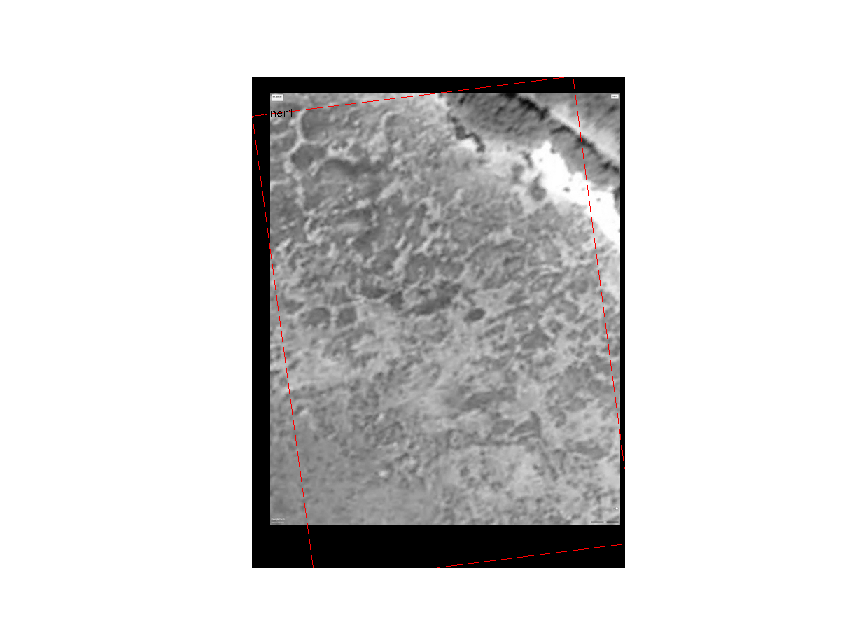

In [12]:
plt.figure(1)
plt.imshow(uavCornersPreview)
plt.axis('off')
plt.show()

In [15]:
print(uavCornersPreview.shape)

(703, 533, 3)
